In [16]:
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from collections import defaultdict, deque
import numpy as np
import time

In [4]:
df = pd.read_csv('sx-stackoverflow.txt', sep=" ", header=None )
df.columns = ['source', 'destination', 'timestamp']
df.head()

,source,destination,timestamp
0,9,8,1217567877
1,1,1,1217573801
2,13,1,1217606247
3,17,1,1217617639
4,48,2,1217618182


In [5]:
df.dropna(inplace=True)  # Drop rows with missing values

# Convert cleaned DataFrame to list of tuples (source, destination, timestamp)
data_tuples = list(df.itertuples(index=False, name=None))

In [4]:
print(len(df))

63497050


In [6]:
# Step 1: Extract and sort timestamps
timestamps = df['timestamp'].sort_values().to_numpy()

# Step 2: Calculate time intervals
intervals = np.diff(timestamps)

# Step 3: Calculate average interval
average_interval = np.mean(intervals)

print(f"Average time interval: {average_interval} seconds")

Average time interval: 3.775066003461043 seconds


In [7]:
# Define the PaCo algorithm
def paco(data, delta, max_length):
    """
    Implements the PaCo algorithm for counting causal paths in temporal networks.
    
    Args:
    - data: List of tuples (source, destination, timestamp).
    - delta: Maximum time difference between consecutive links.
    - max_length: Maximum path length (K).
    
    Returns:
    - path_counts: Dictionary of causal paths and their counts.
    """
    # Sort data by timestamp
    data = sorted(data, key=lambda x: x[2])
    
    # Initialize sliding window and path counters
    window = deque()  # Sliding window
    path_counts = defaultdict(int)  # Overall causal path counts
    
    # Iterate through each link in the data
    for (s, d, t) in data:
        current_counts = defaultdict(int)  # Local counts for current link
        current_counts[(s, d)] = 1  # A single link is a causal path of length 1
        
        # Update the sliding window: remove outdated links
        while window and window[0][2] < t - delta:
            window.popleft()
        
        # Extend paths from the sliding window
        for (prev_s, prev_d, prev_t, prev_counts) in window:
            if prev_d == s and prev_t < t:  # Valid path extension
                for path, count in prev_counts.items():
                    if len(path) < max_length:  # Enforce maximum path length
                        extended_path = path + (d,)
                        current_counts[extended_path] += count
        
        # Update global counts
        for path, count in current_counts.items():
            path_counts[path] += count
        
        # Add current link and its paths to the sliding window
        window.append((s, d, t, current_counts))
    
    return path_counts


In [10]:
delta_values = [300, 600, 900]
max_length_values = [2, 3, 4, 5, 6]
found_paths = []
# Loop through the values and measure execution time
for delta in delta_values:
    for max_length in max_length_values:
        start_time = time.time()  # Record start time
        results = paco(data_tuples, delta, max_length)
        end_time = time.time()  # Record end time
        found_paths.append([len(results), delta, max_length]) # add the amount of found paths to a list to keep track of the increase in found paths
        elapsed_time = end_time - start_time  # Calculate elapsed time
        
        print(f"Max Time Delta: {delta}, Max length: {max_length} -> Time Taken: {elapsed_time:.4f} seconds")

Max Time Delta: 300, Max length: 2 -> Time Taken: 143.4595 seconds
Max Time Delta: 300, Max length: 3 -> Time Taken: 156.1210 seconds
Max Time Delta: 300, Max length: 4 -> Time Taken: 162.4334 seconds
Max Time Delta: 600, Max length: 2 -> Time Taken: 238.2588 seconds
Max Time Delta: 600, Max length: 3 -> Time Taken: 262.7193 seconds
Max Time Delta: 600, Max length: 4 -> Time Taken: 284.3004 seconds
Max Time Delta: 900, Max length: 2 -> Time Taken: 334.0984 seconds
Max Time Delta: 900, Max length: 3 -> Time Taken: 371.8633 seconds
Max Time Delta: 900, Max length: 4 -> Time Taken: 410.4877 seconds


In [ ]:
print(found_paths)

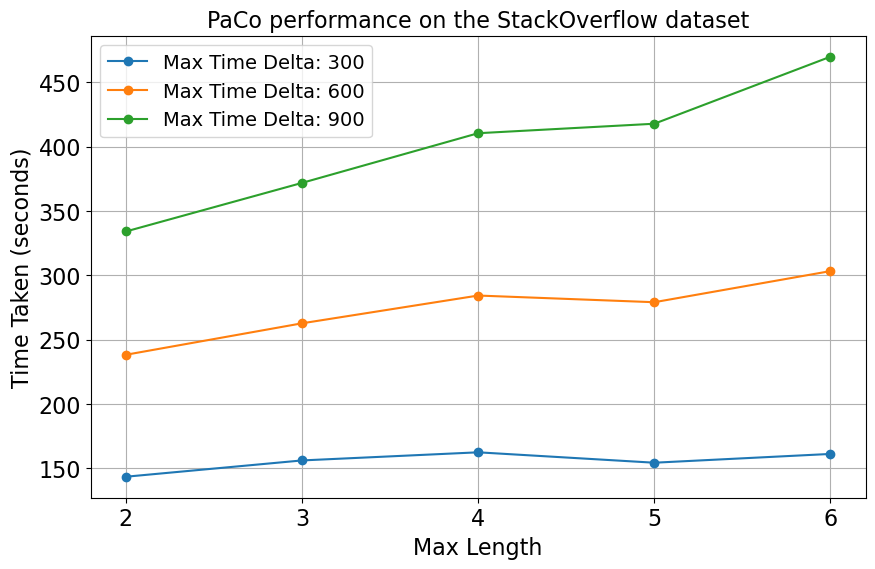

In [18]:
max_lengths = [2, 3, 4, 5, 6]
deltas = [300, 600, 900]

times = {
    300: [143.4595, 156.1210, 162.4334, 154.3476, 161.1703],
    600: [238.2588, 262.7193, 284.3004, 279.1105, 303.2971],
    900: [334.0984, 371.8633, 410.4877, 417.8512, 469.9446]
}

plt.figure(figsize=(10, 6))

for delta in deltas:
    plt.plot(max_lengths, times[delta], marker='o', label=f'Max Time Delta: {delta}')

plt.xlabel('Max Length', fontsize=16)
plt.ylabel('Time Taken (seconds)', fontsize=16)
plt.title('PaCo performance on the StackOverflow dataset', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.xticks(range(2,7), fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [5]:
G_stackoverflow = nx.DiGraph()
for index, row in df.iterrows():
    G_stackoverflow.add_edge(row['source'], row['destination'], timestamp=row['timestamp'])

In [6]:
print(nx.density(G_stackoverflow))

5.351837865909591e-06


In [6]:
call_edge_list = list(df.itertuples(index=False, name=None))
graph = pp.TemporalGraph.from_edge_list(call_edge_list)

In [7]:
delta_values = [300, 600, 900]
max_order_values = [2, 3, 4]

for delta in delta_values:
    for max_order in max_order_values:
        start_time = time.time()  
        temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=max_order)
        end_time = time.time()  
        elapsed_time = end_time - start_time  
        
        print(f"Delta: {delta}, Max Order: {max_order} -> Time Taken: {elapsed_time:.4f} seconds")

: 